In [1]:
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, zscore, pearsonr, wilcoxon
import pybedtools as pbt
from scipy.integrate import simps
from IPython.display import clear_output
import json

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

### Load names of oncogenes downloaded from COSMIC (cancer Genes census list) and obtain there corresponding ENSEMBL transcript ids

In [2]:
oncogenes = []
with open('../data/oncogenes/Census_allFri Apr 14 21-33-23 2017.tsv') as h:
    next(h)
    for l in h:
        c = l.split('\t', 1)
        oncogenes.append(c[0])

tid_to_gene = json.load(open('../data/annotation/gencode_tid_to_gene_name.json'))
oncogenes_tid = {}
for k,v in tid_to_gene.items():
    if v in oncogenes:
        oncogenes_tid[k] = v
len(oncogenes), len(oncogenes_tid)

(616, 6627)

### Load the TSS inf|ormation for all above transcripts and calculate +/- 1 kb tss region

In [3]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_wise_oncogene_info = {}

temp_starts = {}
for chrom in chroms:
    chrom_wise_oncogene_info[chrom] = {'positive': [], 'negative': []}
    with open('../data/annotation/chrom_wise_gencode_tss/%s.bed' % chrom) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            if c[3] in oncogenes_tid:
                gene_name = oncogenes_tid[c[3]]
                if gene_name not in temp_starts:
                    temp_starts[gene_name] = []
                if c[5] == '+':
                    start = int(c[1])
                else:
                    start= int(c[2])
                if start not in temp_starts[gene_name]:
                    up = start - 1000
                    down = start + 1000 + 1
                    strand = 'positive' if c[5] == '+' else 'negative'
                    chrom_wise_oncogene_info[chrom][strand].append(
                        (up, down, gene_name, c[3]))
                    temp_starts[gene_name].append(start)
                    
sum([len(x) for x in temp_starts.values()]), len(temp_starts)

(5804, 602)

### Load the expectation scores in the above regions

In [4]:
def load_scores(chrom, strand):
    in_dir = '/home/parashar/scratch/quadcomb/data/QG_expectation_scores_corrected_values'
    fn = '%s/%s_%s.npy' % (in_dir, chrom, strand)
    return np.load(fn, mmap_mode='r')

gene_sense_exp = []
gene_antisense_exp = []
tid_list = []
for chrom in tqdm(chroms):
    pos_exp = load_scores(chrom, 'positive')
    neg_exp = load_scores(chrom, 'negative')
    for i in chrom_wise_oncogene_info[chrom]['positive']:
        gene_sense_exp.append(pos_exp[i[0]:i[1]])
        gene_antisense_exp.append(neg_exp[i[0]:i[1]])
        tid_list.append(i[3])
    for i in chrom_wise_oncogene_info[chrom]['negative']:
        gene_sense_exp.append(neg_exp[i[0]:i[1]][::-1])
        gene_antisense_exp.append(pos_exp[i[0]:i[1]][::-1])
        tid_list.append(i[3])
gene_sense_exp = np.array(gene_sense_exp)
gene_antisense_exp = np.array(gene_antisense_exp)
gene_sense_exp.shape, gene_antisense_exp.shape, len(tid_list)

100%|██████████| 24/24 [00:00<00:00, 43.29it/s]


((5804, 2001), (5804, 2001), 5804)

### Load G4 motifs in the above regions

In [146]:
def g4_intersect(chrom, bed, loop_len=15):
    g4_fn = "g3_%d_0_%s_nov.bed" % (loop_len, chrom)
    g4 = pbt.BedTool("/home/parashar/scratch/quadruplexes/hg19/%s" % g4_fn)
    intersect = bed.intersect(g4, wo=True)
    tids = {}
    for l in intersect:
        c = str(l).rstrip('\n').split('\t')
        start = max(0, int(c[7]) - int(c[1]))
        end = min(2000, int(c[8]) - int(c[1]))
        a = np.zeros(2001)
        a[start:end] += 1
        t_strand = c[5]
        if t_strand == '-':
            a = a[::-1]
        tname = c[4]
        if tname not in tids:
            tids[tname] = {'sense': np.zeros(2001), 'antisense': np.zeros(2001)}
        
        g4_strand = '+' if c[10][0].upper() == 'G' else '-'
        if g4_strand == t_strand:
            tids[tname]['sense'] += a
        else:
            tids[tname]['antisense'] += a
    return tids

tid_arrays = {}
for chrom in tqdm(chroms):
    t_bed = []
    for strand,s in zip(['positive', 'negative'], ['+', '-']):
        for i in chrom_wise_oncogene_info[chrom][strand]:
            bedline = "\t".join(map(str,
                                [chrom, i[0], i[1], i[2], i[3], s]))
            t_bed.append(bedline)
    t_bed = pbt.BedTool('\n'.join(t_bed), from_string=True)    
    temp_dict = g4_intersect(chrom, t_bed)
    for tid in temp_dict:
        tid_arrays[tid] = temp_dict[tid]

gene_sense_g4 = []
gene_antisense_g4 = []
for tid in tid_list:
    if tid in tid_arrays:
        gene_sense_g4.append(tid_arrays[tid]['sense'])
        gene_antisense_g4.append(tid_arrays[tid]['antisense'])
    else:
        gene_sense_g4.append(np.zeros(2001))
        gene_antisense_g4.append(np.zeros(2001))
gene_sense_g4 = np.array(gene_sense_g4)
gene_antisense_g4 = np.array(gene_antisense_g4)
gene_sense_g4.shape, gene_antisense_g4.shape

100%|██████████| 24/24 [00:06<00:00,  3.94it/s]


((5804, 2001), (5804, 2001))

### Load OQs in the above regions

In [196]:
def oq_intersect(chrom, transcript_bed):
    oq_fn = '../data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed' % chrom
    oq_bed = pbt.BedTool(oq_fn)
    intersect = transcript_bed.intersect(oq_bed, wo=True)
    tids = {}
    for l in intersect:
        c = str(l).rstrip('\n').split('\t')
        if int(c[10]) > 1:
            start = max(0, int(c[7]) - int(c[1]))
            end = min(2000, int(c[8]) - int(c[1]))
            a = np.zeros(2001)
            a[start:end] += 1
            t_strand = c[5]
            if t_strand == '-':
                a = a[::-1]
            tname = c[4]
            if tname not in tids:
                tids[tname] = {'sense': np.zeros(2001), 'antisense': np.zeros(2001)}
            oq_strand = '+' if c[9] == '-' else '-'
            if oq_strand == t_strand:
                tids[tname]['sense'] += a
            else:
                tids[tname]['antisense'] += a
    return tids

tid_arrays = {}
for chrom in tqdm(chroms):
    t_bed = []
    for strand,s in zip(['positive', 'negative'], ['+', '-']):
        for i in chrom_wise_oncogene_info[chrom][strand]:
            bedline = "\t".join(map(str,
                                [chrom, i[0], i[1], i[2], i[3], s]))
            t_bed.append(bedline)
    t_bed = pbt.BedTool('\n'.join(t_bed), from_string=True)    
    temp_dict = oq_intersect(chrom, t_bed)
    for tid in temp_dict:
        tid_arrays[tid] = temp_dict[tid]

gene_sense_oq = []
gene_antisense_oq = []
for tid in tid_list:
    if tid in tid_arrays:
        gene_sense_oq.append(tid_arrays[tid]['sense'])
        gene_antisense_oq.append(tid_arrays[tid]['antisense'])
    else:
        gene_sense_oq.append(np.zeros(2001))
        gene_antisense_oq.append(np.zeros(2001))
gene_sense_oq = np.array(gene_sense_oq)
gene_antisense_oq = np.array(gene_antisense_oq)
gene_sense_oq.shape, gene_antisense_oq.shape

100%|██████████| 24/24 [00:04<00:00,  5.77it/s]


((5804, 2001), (5804, 2001))

In [182]:
def make_ranges(a):
    ranges = []
    for s,e in zip(np.where(np.diff(a) > 0)[0], np.where(np.diff(a) < 0)[0]):
        ranges.append(list(range(s+1,e+1)))
    return ranges   

def g4_exp_overlap(g4_arrays, exp_arrays, cutoff=0.01):    
    overlap = []
    total = []
    for g,e in zip(g4_arrays, exp_arrays):
        e = np.where(e > cutoff)[0]
        tg, tl, to, tot = len(e), 0, 0, 0
        for r in make_ranges(g):
            tot += 1
            len_intersect = len(set(r).intersection(e))
            if len_intersect > 0:
                to += 1
        overlap.append(to)
        total.append(tot)
    return np.array(overlap), np.array(total)

s_overlap, s_total_g4s = g4_exp_overlap(gene_sense_g4, gene_sense_exp)
as_overlap, as_total_g4s = g4_exp_overlap(gene_antisense_g4, gene_antisense_exp)

In [101]:
sum(s_total_g4s), sum(as_total_g4s), sum(s_total_g4s) + sum(as_total_g4s)

(12246, 10033, 22279)

In [112]:
print (len(np.where((s_total_g4s + as_total_g4s) > 0)[0]),
       len(np.where((s_total_g4s + as_total_g4s) > 0)[0])/len(as_total_g4s)*100)

4307 74.20744314266024


In [116]:
exp_ctr = 0
for i in range(gene_sense_exp.shape[0]):
    if len(np.where(gene_sense_exp[i] > 0.01)[0]) > 0 or \
       len(np.where(gene_antisense_exp[i] > 0.01)[0]) > 0:
        exp_ctr += 1
print (exp_ctr, exp_ctr/gene_sense_g4.shape[0]*100)

5210 89.7656788421778


In [119]:
sum(s_overlap) + sum(as_overlap), (sum(s_overlap) + sum(as_overlap))/(sum(s_total_g4s) + sum(as_total_g4s))

(17568, 0.78854526684321558)

In [121]:
len(np.where((s_overlap + as_overlap) > 0)[0])

4055

In [240]:
ctr = []
for i,j,a,b,n in zip(gene_sense_g4, gene_antisense_g4,
                   gene_sense_exp, gene_antisense_exp, range(gene_antisense_exp.shape[0])):
    if sum(i)+sum(j) == 0:
        if len(np.where(a > 0.01)[0]) > 0 or len(np.where(b > 0.01)[0]) > 0:
            ctr.append(n)
len(ctr)

938

In [241]:
high_conf_genes = {}
for i in np.array(tid_list)[ctr]:
    if oncogenes_tid[i] not in high_conf_genes:
        high_conf_genes[oncogenes_tid[i]] = []
    high_conf_genes[oncogenes_tid[i]].append(i)
print (len(high_conf_genes))
    
for i in high_conf_genes:
    if len(high_conf_genes[i]) > num_transcripts[i]/2:
        print (i, len(high_conf_genes[i]),  num_transcripts[i])

323
CREBBP 11 20
SETD2 6 8
HIST1H3B 1 1
WRN 2 3
LRIG3 5 9
BUB1B 6 11
SND1 11 16
SBDS 5 5
TAL2 1 1
BIRC3 6 7
MDS2 2 3
LCP1 4 7
PRDM1 6 7
PDCD1LG2 1 1
SFPQ 6 10
FANCD2 9 13
IL7R 8 10
SSX2 2 3
FCRL4 2 3
SSX1 1 1
ARHGAP26 11 20
TNFRSF17 2 3


In [197]:
def g4_oq_overlap(g4_arrays, oq_arrays):
    overlap = []
    total = []
    for g,o in zip(g4_arrays, oq_arrays):
        to, tot = 0, 0
        g = np.where(g > 0)[0]
        for r in make_ranges(o):
            tot += 1
            len_intersect = len(set(r).intersection(g))
            if len_intersect > 0:
                to += 1
        overlap.append(to)
        total.append(tot)
    return np.array(overlap), np.array(total)

gq_s_overlap, gq_s_total_g4s = g4_oq_overlap(gene_sense_g4, gene_sense_oq)
gq_as_overlap, gq_as_total_g4s = g4_oq_overlap(
    gene_antisense_g4, gene_antisense_oq)

In [198]:
gq_s_total_g4s.sum() + gq_as_total_g4s.sum()

2760

In [199]:
print (len(np.where((gq_s_total_g4s + gq_as_total_g4s) > 0)[0]),
       len(np.where((gq_s_total_g4s + gq_as_total_g4s) > 0)[0])/len(gq_s_total_g4s)*100)

2051 35.33769813921433


In [200]:
print (gq_s_overlap.sum() + gq_as_overlap.sum(),
       (gq_s_overlap.sum() + gq_as_overlap.sum())/ (gq_s_total_g4s.sum() + gq_as_total_g4s.sum()))

1981 0.717753623188


In [201]:
print (len(np.where((gq_s_overlap + gq_as_overlap) > 0)[0]),
       len(np.where((gq_s_overlap + gq_as_overlap) > 0)[0])/len(gq_s_total_g4s)*100)

1605 27.653342522398344


In [202]:
def oq_exp_overlap(oq_arrays, exp_arrays, cutoff=0.01):    
    overlap = []
    total = []
    for o,e in zip(oq_arrays, exp_arrays):
        e = np.where(e > cutoff)[0]
        to, tot = 0, 0
        for r in make_ranges(o):
            tot += 1
            len_intersect = len(set(r).intersection(e))
            if len_intersect > 0:
                to += 1
        overlap.append(to)
        total.append(tot)
    return np.array(overlap), np.array(total)

oe_s_overlap, oe_s_total_g4s = oq_exp_overlap(gene_sense_oq, gene_sense_exp)
oe_as_overlap, oe_as_total_g4s = oq_exp_overlap(
    gene_antisense_oq, gene_antisense_exp)

In [203]:
print (len(np.where((oe_s_total_g4s + oe_as_total_g4s) > 0)[0]),
       len(np.where((oe_s_total_g4s + oe_as_total_g4s) > 0)[0])/len(oe_s_total_g4s)*100)

2051 35.33769813921433


In [204]:
print (oe_s_overlap.sum() + oe_as_overlap.sum(),
       (oe_s_overlap.sum() + oe_as_overlap.sum())/ (oe_s_total_g4s.sum() + oe_as_total_g4s.sum()))

2417 0.875724637681


In [180]:
print (len(np.where((oe_s_overlap + oe_as_overlap) > 0)[0]),
       len(np.where((oe_s_overlap + oe_as_overlap) > 0)[0])/len(oe_s_total_g4s)*100)

3052 52.58442453480359


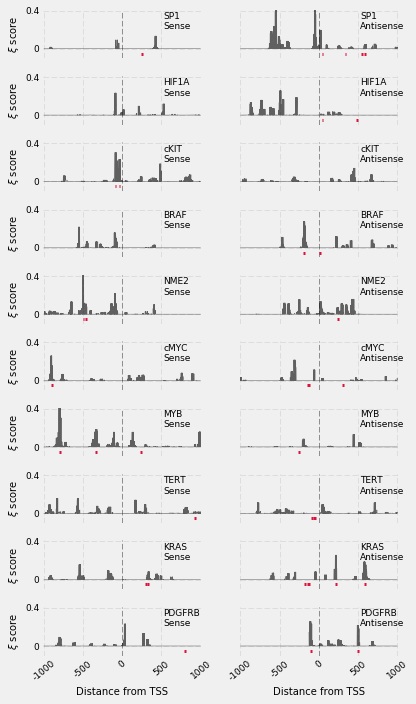

In [322]:
fig, axis = plt.subplots(10, 2, figsize=(6, 10))
for row,gene in enumerate(promoters):
    strand = promoters[gene][3]
    sense = get_span_exp_score(promoters[gene][0], promoters[gene][1],
                               promoters[gene][2], strand)
    antistrand = '+' if strand == '-' else '-'
    antisense = get_span_exp_score(promoters[gene][0], promoters[gene][1],
                                   promoters[gene][2], antistrand)
    if strand == '-':
        sense = sense[::-1]
        antisense = antisense[::-1]
    promoter_exp = [sense, antisense]
    
    for col in [0, 1]:
        ax = axis[row, col]
        ax.plot(list(range(2000)), promoter_exp[col], lw=0.5, alpha=0.6, color='k')
        ax.axvline(1000, ls='--', color='k', alpha=0.7, lw=0.5)
        print_strand = '%s\nSense' % gene if col == 0 else '%s\nAntisense' % gene
        ax.text(0.76, 0.6, print_strand, transform=ax.transAxes, fontsize=9)
        for g4_span in g4_promoters[gene][col]:
            r = list(range(g4_span[0], g4_span[1]))
            ax.plot(r, [-0.05 for x in range(r[-1] - r[0] + 1)], lw=3, color='crimson')

        for j in ['top', 'bottom', 'left', 'right']:
            ax.spines[j].set_visible(False)
        ax.grid(which='major', linestyle='--', alpha=0.5)
        ax.set_yticks([0, 0.4])
        if col == 1:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([0, 0.4])
            ax.set_ylabel(r'$\xi$' + ' score', fontsize=10)
        ax.set_xticks([0, 500, 1000, 1500, 2000])
        if row == 9:
            ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=40, fontsize=9)
            ax.set_xlabel('Distance from TSS', fontsize=10)
        else:
            ax.set_xticklabels([])
        ax.xaxis.set_tick_params(labelsize=9)
        ax.yaxis.set_tick_params(labelsize=9) 
        ax.set_xlim(-10, 2010)
        ax.set_ylim((-0.1, 0.41))
plt.savefig('../images/promoters_blow_out.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/promoter_blow_out.svg', transparent=True, edgecolor='none')
plt.tight_layout()
plt.show()